In [ ]:
!pip install git+https://github.com/openopt/copt.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openopt/copt.git to /tmp/pip-req-build-28wjkj9j
  Running command git clone -q https://github.com/openopt/copt.git /tmp/pip-req-build-28wjkj9j
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for copt: filename=copt-0.9.0-py3-none-any.whl size=37601 sha256=b9877cb06facc589c029cabb0d20b1c29766df35591ab33f3cfa2a367fff36a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-n26p7_jg/wheels/5a/2c/24/8c054b4fcfd93eec7d7b66ffe099ebc66fabbb9fe06f6bb982
Successfully built copt


In [ ]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import numpy as np
import copt

# .. for plotting ..
import pylab as plt
# .. to generate a synthetic dataset ..
from sklearn import datasets
from tqdm import tqdm

import seaborn as sns
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from time import process_time_ns

import jax.scipy.optimize as sopt
from sklearn import datasets
import jax.numpy as jnp
from jax import grad, jit, vmap, hessian

from scipy.optimize import minimize

from jax.experimental import sparse
from sklearn.preprocessing import StandardScaler

def f(A, b, Lambda, x):
    return jnp.mean(jnp.log(1 + jnp.exp(-jnp.multiply(b, A.dot(x))))) + Lambda / 2 * jnp.sum(jnp.multiply(x, x))

# wine = datasets.load_wine()
A, b = copt.datasets.load_madelon()
A = A.todense()

A, A_test, b, b_test = train_test_split(A, b, test_size=0.3, random_state=42)

scaler = StandardScaler()
A = scaler.fit_transform(A)
A_test = scaler.fit_transform(A_test)

b = b.astype('float32')
A = jnp.array(A)
b = jnp.array(b)
b = b.reshape(-1, 1)

Lambda = 1.0 / A.shape[0]

n_features = A.shape[1]
n_samples = A.shape[0]

x0 = jnp.zeros((n_features, 1), dtype=jnp.float32)
H = hessian(f, argnums=3)(A, b, 1.0, x0)
H = jnp.squeeze(H)
print(H.shape)
# L = np.linalg.eigvals(H).max()
# print(L)
n_iters = 100000
eigenvalue = 0
u = np.ones((n_features, 1))
for i in tqdm(range(n_iters)):
    u = H@u
    eigenvalue = np.max(u)
    u = u/eigenvalue
L = eigenvalue
print("\n\n", L)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn

(500, 500)


100%|██████████| 100000/100000 [00:06<00:00, 15677.06it/s]



 2.0915167


In [ ]:
def predef_decreasing_seq(t):
    '''
        Compute predefined decreasing sequence for stepsize.

        t(int) - timestep.
    '''
    return 2.0 / (t + 2.0)

def exact_line_search(opt_line_search, *args):
    '''
        Compute exact line-search sequence for stepsize.

        gamma_opt - solution for argmin_{c \in C} (grad f, c);
        qt(ndarray) - A(st - xt).
    '''

    gamma_t = opt_line_search(*args)

    return min(gamma_t, 1.)

def DR_stepsize(dt, gt, L):
    '''
        Demyanov-Rubinov sequence for stepsize.
        dt(sparse vector) - st - xt;
        gt(float) - <-grad f, dt>, stopping criterion(how our direction correlates with gradient);
        L - Lipschitz constant of gradient f.
    '''

    return min((1 / L) * gt / (dt * dt).sum(), 1.)

def backtracking_linesearch(xt, dt, gt, Mt, eta, tau, f, Q, *args):
    '''
        eta <= 1, tau > 1.
    '''

    Mt = eta * Mt
    gamma_t = DR_stepsize(dt, gt, Mt)
    f_xt = f(*args, xt)
    while f(*args, xt + gamma_t * dt) > Q(f_xt, gt, dt, gamma_t, Mt):
        Mt = tau * Mt
        gamma_t = DR_stepsize(dt, gt, Mt)

    return gamma_t, Mt

100%|██████████| 400/400 [00:06<00:00, 60.53it/s]


Density of solution: 36.00%


100%|██████████| 400/400 [00:23<00:00, 17.07it/s]


Density of solution: 0.60%


100%|██████████| 400/400 [00:06<00:00, 61.65it/s]


Density of solution: 12.80%


100%|██████████| 400/400 [00:07<00:00, 55.87it/s]


Density of solution: 33.00%


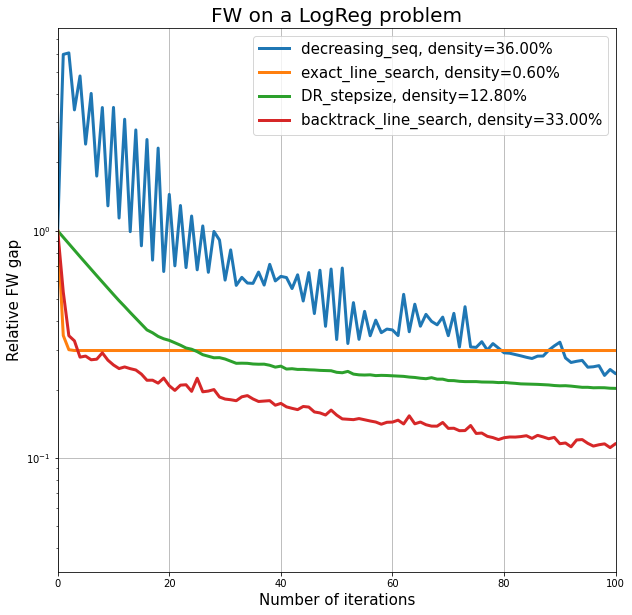

In [ ]:
def f_gamma(A, b, Lambda, x, dt, gamma):
    return f(A, b, Lambda, x + dt * gamma)

def f_jac(gamma, A, b, Lambda, x, dt):
      return (f_gamma(A, b, Lambda, x, dt, gamma), grad(f_gamma, 5)(A, b, Lambda, x, dt, gamma))

def logreg_gamma_opt(A, b, Lambda, xt, dt):
    gamma0 = 0
    return minimize(f_jac, gamma0, args=(A, b, Lambda, xt, dt), jac=True, method='Newton-CG', tol=1e-6).x

def Q(f_xt, gt, dt, gamma_t, Mt):
    return f_xt - gamma_t * gt + 0.5 * gamma_t**2 * Mt * ((dt * dt).sum())

def FW(alpha, max_iter=100, tol=1e-8, callback=None, scheduler=None):
    # .. initial estimate, could be any feasible point ..
    x_t = jnp.zeros((n_features, 1), dtype=jnp.float32)

    args = scheduler["args"]
    Mt = None


    for it in tqdm(range(max_iter)):
        # .. compute gradient. Slightly more involved than usual because ..
        # .. of the use of sparse matrices ..
        
        grad_f = grad(f, 3)(A, b, Lambda, x_t)
        # print(x_t, f(A, b, Lambda, x_t), grad_f, "\n\n\n")

        # .. the LMO results in a vector that is zero everywhere except for ..
        # .. a single index. Of this vector we only store its index and magnitude ..
        idx_oracle = jnp.argmax(jnp.abs(grad_f))
        mag_oracle = alpha * jnp.sign(-grad_f[idx_oracle])
        d_t = -x_t.copy()
        temp = d_t[idx_oracle]

        d_t = d_t.at[idx_oracle].set(temp + mag_oracle)

        if it == 0 and scheduler["name"] == "backtrack_line_search":
            eps = args["eps"]
            # |grad f(x0)  - grad f(x0 + eps d0)| / |eps * d0|

            grad_fd = grad(f, 3)(A, b, Lambda, x_t + eps * d_t)
            numerator = jnp.linalg.norm(grad_f - grad_fd, ord=2)
            denominator = eps * jnp.linalg.norm(d_t, ord=2)

            Mt = numerator / denominator

        g_t = - d_t.T.dot(grad_f).ravel()[0]

        if g_t <= tol:
            break

        step_size = 0.0
        if scheduler["name"] == "decreasing_seq":
            step_size = predef_decreasing_seq(it)
        elif scheduler["name"] == "exact_line_search":
            step_size = exact_line_search(args["opt_line_search"], A, b, Lambda, x_t, d_t)
        elif scheduler["name"] == "DR_stepsize":
            step_size = DR_stepsize(d_t, g_t, args["L"])
        elif scheduler["name"] == "backtrack_line_search":
            step_size, Mt = backtracking_linesearch(x_t, d_t, g_t, Mt, args["eta"], args["tau"],
                                                    args["f"], args["Q"], A, b, Lambda)

        if callback is not None:
            callback(g_t, f(A, b, Lambda, x_t))

        x_t += step_size * d_t

    return x_t

def run(alpha, scheduler):
    '''
        alpha - constraint parameter
        scheduler(dict) - name of the stepsize decreasing method;
        
        scheduler has fields:
        "name"(str): one of ["decreasing_seq", "exact_line_search", "DR_stepsize", "backtrack_line_search"]
        "args"(dict): if "exact_line_search" then you should pass linreg_gamma_opt func which solves linesearch
                if "backtrack_line_search" then you should pass eta and tau
                if "DR_stepsize" then you should pass L(Lipschitz constant of gradient)
                in other cases it should be None
    '''
    trace = []
    loss = []

    def callback(g_t, f_t):
        trace.append(g_t)
        loss.append(f_t)

    sol = FW(alpha, max_iter=400, callback=callback, scheduler=scheduler)
    trace_np = np.array(trace)
    density = jnp.mean(sol.ravel() != 0)


    plt.plot(trace_np / trace_np[0], lw=3, label=scheduler["name"] + ', density={:2.2%}'.format(density))

    print("Density of solution: %.2f%%" % (density * 100))
    return sol

decr_seq_scheduler = {"name": "decreasing_seq", "args": None}
ExactLS_scheduler = {"name": "exact_line_search", "args": {"opt_line_search": logreg_gamma_opt}}
DR_scheduler = {"name": "DR_stepsize", "args": {"L": L}}
BCLS_scheduler = {"name": "backtrack_line_search", "args": {"eps": 1e-3,
                                                       "f": f,
                                                       "Q": Q,
                                                       "tau": 2.0,
                                                       "eta": 0.9}}

exps = [decr_seq_scheduler, ExactLS_scheduler, DR_scheduler, BCLS_scheduler]

plt.figure(figsize=(10, 10))
sols = list()
# alpha = 0.8 * n_features
alpha = 10.0
for exp in exps:
    sols.append(run(alpha, exp))


plt.yscale('log')
plt.xlabel('Number of iterations', fontsize=15)
plt.ylabel('Relative FW gap', fontsize=15)
plt.title('FW on a LogReg problem', fontsize=20)
plt.legend(fontsize=15)
plt.xlim((0, 100))
plt.grid()
plt.savefig('beta_10.png')
plt.show()

Running on the Madelon dataset
25.87501117004955
Accuracy on Madelon is : 0.6088461538461538
162.58441864465277
Accuracy on Madelon is : 0.6057692307692307
Sparsity of solution: 0.004


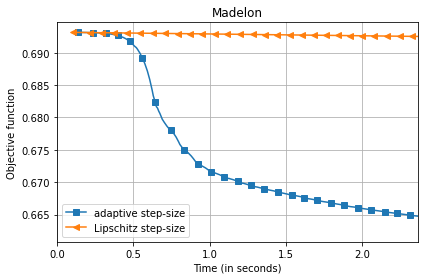

In [ ]:
from sklearn.metrics import accuracy_score

# .. datasets and their loading functions ..
# import copt.constraint
# import copt.loss

datasets = [
    # ("Gisette", copt.datasets.load_gisette, 6e3),
    # ("RCV1", copt.datasets.load_rcv1, 2e4),
    ("Madelon", copt.datasets.load_madelon, 20.0)
    # ("Covtype", copt.datasets.load_covtype, 200.0),
]

variants_fw = [
    ["backtracking", "adaptive step-size", "s"],
    ["DR", "Lipschitz step-size", "<"],
]

for dataset_title, load_data, alpha in datasets:
    plt.figure()
    print("Running on the %s dataset" % dataset_title)

    X, y = load_data()
    n_samples, n_features = X.shape

    l1_ball = copt.constraint.L1Ball(alpha)
    f = copt.loss.LogLoss(X, y)
    x0 = np.zeros(n_features)

    for step, label, marker in variants_fw:

        cb = copt.utils.Trace(f)
        sol = copt.minimize_frank_wolfe(
            f.f_grad, x0, l1_ball.lmo, callback=cb, step=step, lipschitz=f.lipschitz
        )
        print(sol.certificate)
        predictFW = (np.sign(X @ sol.x.reshape(-1, 1)) + 1) / 2
        print(f"Accuracy on {dataset_title} is :", accuracy_score(y, predictFW))

        plt.plot(cb.trace_time, cb.trace_fx, label=label, marker=marker, markevery=10)

    print("Sparsity of solution: %s" % np.mean(np.abs(sol.x) > 1e-8))
    plt.legend()
    plt.xlabel("Time (in seconds)")
    plt.ylabel("Objective function")
    plt.title(dataset_title)
    plt.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.xlim((0, 0.7 * cb.trace_time[-1]))  # for aesthetics
    plt.grid()
    plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty="l2", C=1/Lambda, max_iter=30000, random_state=0).fit(A, b.ravel())

In [ ]:
print("Accuracy on train data:", clf.score(A, b.ravel()))
print("Accuracy on test data:", clf.score(A_test, b_test))

Accuracy on train data: 0.7714285714285715
Accuracy on test data: 0.5269230769230769


In [ ]:
density = jnp.mean(clf.coef_.ravel() != 0)
print('Density of solution from sklearn: %s%%' % (density * 100))

Density of solution from sklearn: 100.0%


In [ ]:
solFW = sols[2]
predictFW = (np.sign(A_test @ solFW) + 1) / 2
accuracy_score(b_test, predictFW)

0.7175824175824176